<span style="font-size:10pt">AI @ ENSPIMA_2022-2023_v1.0_Jean-Luc CHARLES (Jean-Luc.charles@ensam.eu)_CC BY-SA 4.0</span>

# Problem-based learning
# Training a neural network to diagnose bearing faults - part 2 / 3

### Targeted learning objectives:
Part 1:<br>
- Know how to load files in *Matlab MAT-file* format with *Python*.
- Know how to dimension and fill numpy ndarrays with the data of the `.mat` files
- Know how to display a grid of data plots
- Know how to store the numpy ndarrays in a `.npz` file

Part 2:<br>
- Know how to load a `.npz` into numpy ndarrays
- Know how to process the temporal dataset to get a spectral dataset.
- Know how to display a grid of spectra plots.

Part 3:<br>
- Know how to train/operate a DNN to diagnose bearing faults using a labeled temporal dataset.
- The problem part of the APP: Know how to train/operate a DNN to diagnose bearing faults using a labeled temporal dataset.

<br>
<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:12pt"> 
It is important to use a <span style="font-weight:bold;">Python Virtual Environment</span> (PVE) for your main Python projects: <br>
    a PVE makes it possible to control for each project the versions of the Python interpreter and the "sensitive" modules (like tensorflow).<br><br>
    All the notebooks your work on must be loaded into a jupyter-notebook or a jupyter-lab launched in the PVE 
    <b><span style="color: rgb(100, 151, 202);" >pyml-pm</span></b> specially created for the session.<br>
</span></div>

In [1]:
import os, sys
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# 2 $-$ Load the *CWRU* data with the `.npz` numpy file

Print the list of the `.npz` files in the current directory:

In [2]:
[ f for f in os.listdir() if f.endswith('.npz')]

['CWRU_dadaset.npz']

`numpy.load` loads the wanted `.npz` file  and returns a dict object

In [3]:
npzfile = np.load('CWRU_dadaset.npz')
list(npzfile.keys())

['arr_0', 'arr_1', 'arr_2']

Thanks to the `dict.value` method, we can define `A`, `B` and `C` the ndarrays associated with the keys:

In [4]:
A, B, C = npzfile.values()

Plot the data to verify (same Python instructions as in the part1 notebook) ...

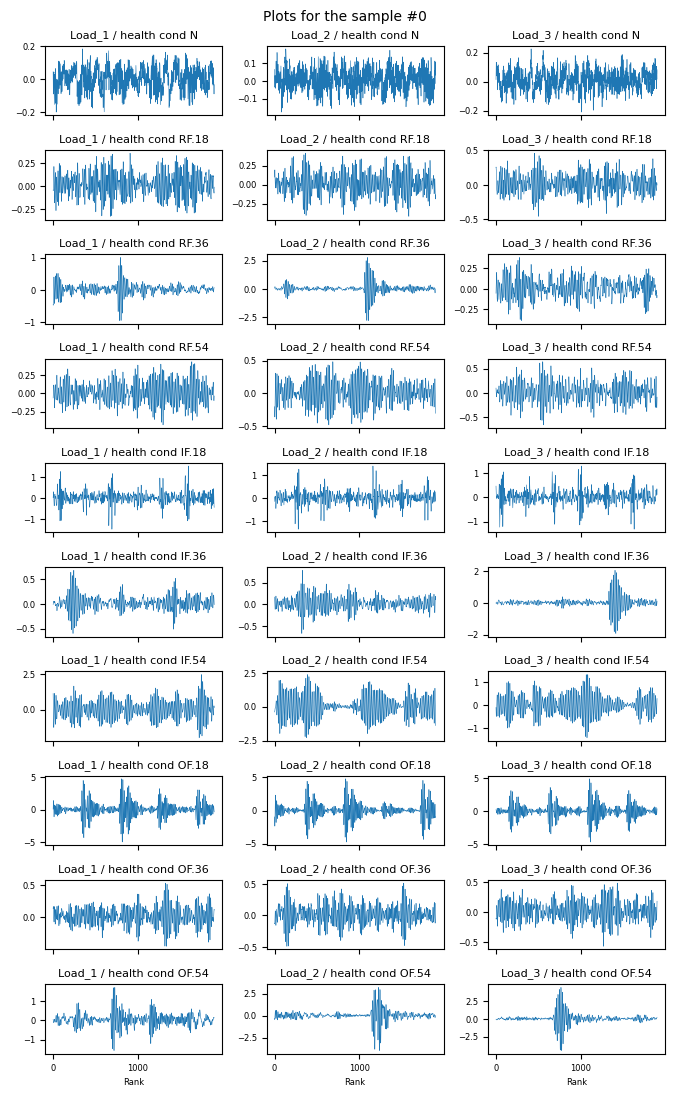

In [5]:
# create the list of the health condition labels:
health_cond = ['N']
for def_type in 'RF', 'IF', 'OF':
    for size in '18', '36', '54':
        health_cond.append(f"{def_type}.{size}")
nb_HC = len(health_cond)

full_dataset = (A, B, C)
nb_L = len(full_dataset)

s = 0  # the sample number to plot

plt.rcParams['font.size'] = 6   # change the pyplot defaut font size
fig, axes = plt.subplots(nb_HC, nb_L, sharex=True)
fig.set_size_inches((8,12))
plt.subplots_adjust(top=.95, wspace=0.25, hspace=0.5)
plt.suptitle(f"Plots for the sample #{s}", fontsize=10)
for n, dataset in enumerate(full_dataset):
    for h in range(nb_HC):
        axe = axes[h,n]
        axe.set_title(f"Load_{n+1} / health cond {health_cond[h]}", fontsize=8)
        axe.plot(dataset[h, s], linewidth=0.4)
        if h == nb_HC-1: axe.set_xlabel("Rank")
plt.rcParams['font.size'] = 10  # restore the pyplot defaut font size to its defautl value

# 3 $-$ Compute and plot the data in the spectral domain

## 3.1 $-$ Compute the spectral datasets

Let's retrieve the temporal shape of the array A:

In [6]:
nb_HC, nb_sample, sample_size = A.shape
print(f"array A has <{nb_sample}> samples of <{sample_size}> data point for each of the <{nb_HC}> health conditions ")

array A has <200> samples of <1900> data point for each of the <10> health conditions 


The spectra are computed with [numpy.fft.rfft](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html)<br>
On the web page, you can see that how to compute the size of the spectrum:

In [7]:
if sample_size % 2 == 0:
    spectrum_size = int(sample_size/2+1)
else:
    spectrum_size = int((sample_size+1)/2)
print(f"size of spectra: {spectrum_size}")    

size of spectra: 951


Now let's define and dimension 3 ndarrays to store the spectra of the 3 temporal data arrays:

In [8]:
A_spectrum = np.ndarray((nb_HC, nb_sample, spectrum_size), dtype=float)
B_spectrum = np.ndarray((nb_HC, nb_sample, spectrum_size), dtype=float)
C_spectrum = np.ndarray((nb_HC, nb_sample, spectrum_size), dtype=float)

and let's compute the spectra with the `np.fft.rfft` function:

In [9]:
for spectrum, dataset in zip((A_spectrum, B_spectrum, C_spectrum), (A, B, C)):
    for hc in range(nb_HC):
        for sample in  range(nb_sample):
            rfft = np.abs(np.fft.rfft(dataset[hc, sample]))   # we take the module of the Fourier spectrum
            spectrum[hc, sample] = rfft/rfft.max()            # we normalize the spectum to get values in [0,1]

Let's draw the spectra of the first sample:

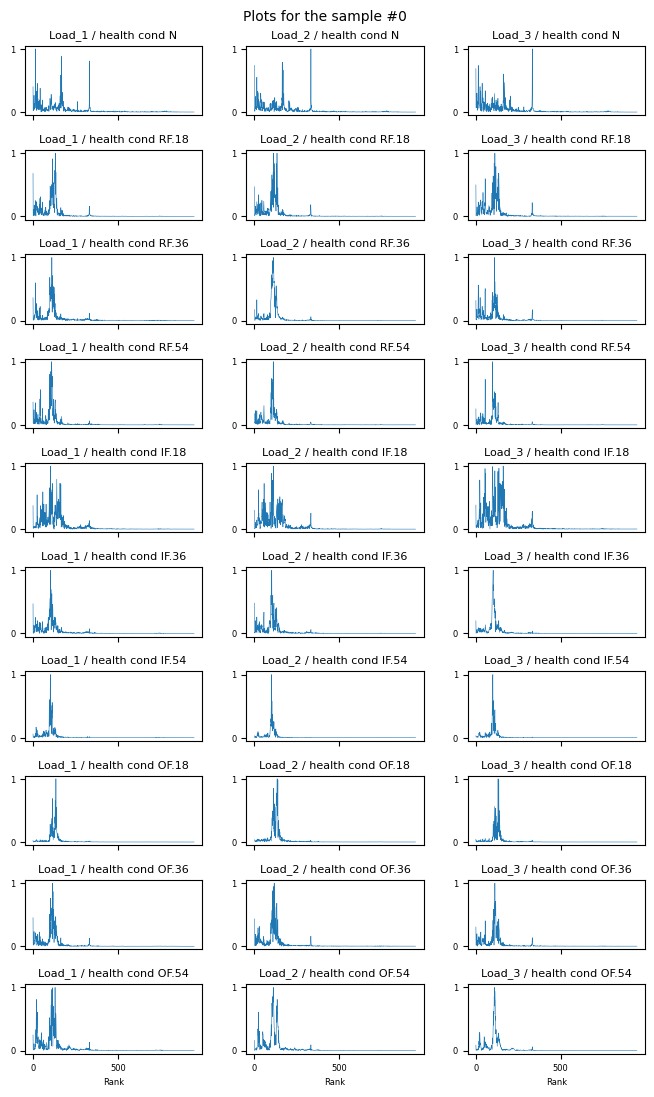

In [10]:
DATA = (A_spectrum, B_spectrum, C_spectrum)
nb_L = len(DATA)

s = 0  # the sample number

plt.rcParams['font.size'] = 6   # change the pyplot defaut font size
fig, axes = plt.subplots(nb_HC, nb_L, sharex=True)
fig.set_size_inches((8,12))
plt.subplots_adjust(top=.95, wspace=0.25, hspace=0.5)
plt.suptitle(f"Plots for the sample #{s}", fontsize=10)
for n, dataset in enumerate(DATA):
    for hc in range(nb_HC):
        axe = axes[hc,n]
        axe.set_title(f"Load_{n+1} / health cond {health_cond[hc]}", fontsize=8)
        axe.plot(dataset[hc, s], linewidth=0.4)
        if hc == nb_HC-1: axe.set_xlabel("Rank")
plt.rcParams['font.size'] = 10  # restore the pyplot defaut font size to its defautl value

## 3.2 $-$ About the spectra size

As you can see from the previous plot, the spectrum is significant only for low frequencies: we can truncate the spectra size without loosing information on the vibration footprint of the default.<br>

Hereafter we plot the spectra for sample #0 with only the first 400 spectral points:

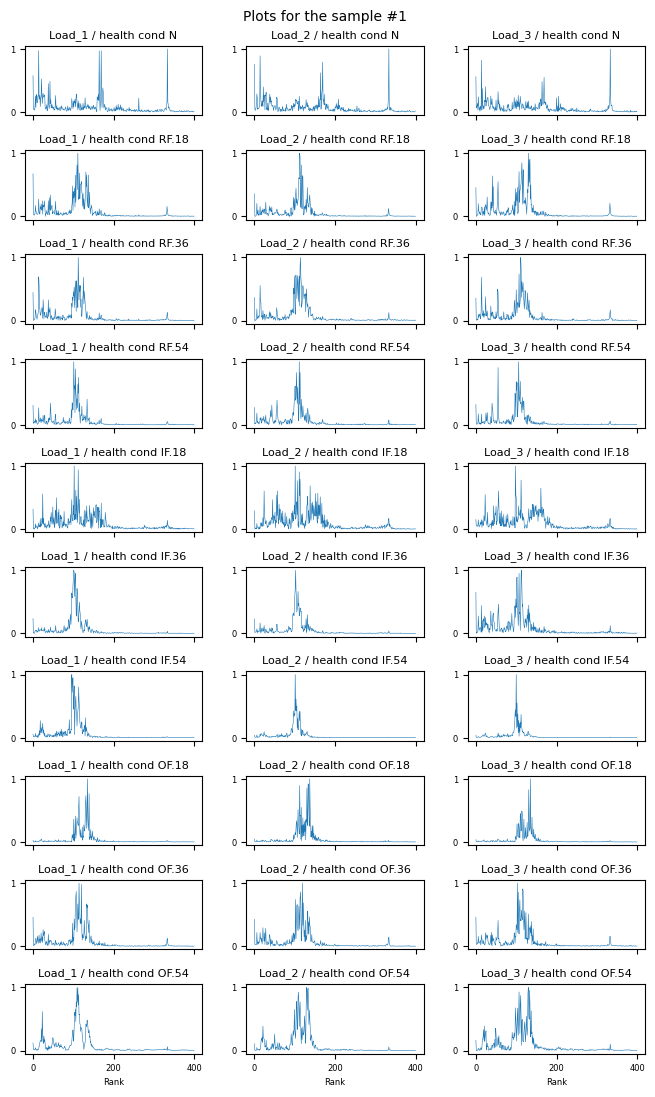

In [11]:
DATA = (A_spectrum, B_spectrum, C_spectrum)
nb_L = len(DATA)
s = 1  # the sample number

plt.rcParams['font.size'] = 6   # change the pyplot defaut font size
fig, axes = plt.subplots(nb_HC, nb_L, sharex=True)
fig.set_size_inches((8,12))
plt.subplots_adjust(top=.95, wspace=0.25, hspace=0.5)
plt.suptitle(f"Plots for the sample #{s}", fontsize=10)
for n, dataset in enumerate(DATA):
    for hc in range(nb_HC):
        axe = axes[hc,n]
        axe.set_title(f"Load_{n+1} / health cond {health_cond[hc]}", fontsize=8)
        axe.plot(dataset[hc, s, :400], linewidth=0.4)
        if hc == nb_HC-1: axe.set_xlabel("Rank")
plt.rcParams['font.size'] = 10  # restore the pyplot defaut font size to its defautl value